In [1]:
import os
import json

from tqdm import tqdm
from tqdm import trange

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import mygene

In [ ]:
import pickle
def read_pickled_object(file_name: str):
    # Ensure the file has the correct .pickle extension
    if '.' in file_name:
        p = pathlib.Path(file_name)
        extensions = "".join(p.suffixes)
        file_name = str(p).replace(extensions, '.pickle')
    else:
        file_name = file_name + '.pickle'

    # Read and deserialize the object
    with open(file_name, 'rb') as handle:
        return pickle.load(handle)

In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

<span style="color:red;">Arjana: If loading the pickled object doesn't work, you shouldn't need it you should be able to load the model_coefs csv from the files I sent. Just including everything so you can see how things were run.</span> 

In [3]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean'].values.ravel()

# Read the list from the file
with open('protein_cols.txt', "r") as file:
    protein_cols = [line.strip() for line in file]
with open('rna_cols.txt', "r") as file:
    rna_cols = [line.strip() for line in file]

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values

best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))



ID mapping between protein and RNA:

In [16]:
# # map from uniprot ID to gene name
# uniprot_ids = list(set([protein_id.split('|')[1].split('-')[0] for protein_id in protein_cols]))
# mg = mygene.MyGeneInfo()
# uid_maps = mg.querymany(uniprot_ids, scopes="uniprot", fields="symbol", species="human")
# uid_mapper = {pn.get('query'): pn.get('symbol', np.nan) for pn in uid_maps}
# with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "w") as json_file:
#     json.dump(uid_mapper, json_file, indent=4)
with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "r") as json_file:
    uid_mapper = json.load(json_file)
    
# manually mapped some that failed to map using uniprot ID
manual_map = {'Q9TNN7': 'HLA-C',
'P16189': 'HLA-A',
'P30456': 'HLA-A',
'P30443': 'HLA-A',
'P05534': 'HLA-A',
'P18462': 'HLA-A',
'P01892': 'HLA-A',
'P13746': 'HLA-A',
'P01891': 'HLA-A',
'P30483': 'HLA-B',
'P30484': 'HLA-B',
'P03989': 'HLA-B',
'P30460': 'HLA-B',
'P30461': 'HLA-B',
'Q95365': 'HLA-B',
'P16188': 'HLA-A',
'Q95604': 'HLA-C',
'Q07000': 'HLA-C',
'P30499': 'HLA-C',
'P30501': 'HLA-C',
'P30504': 'HLA-C',
'Q95IE3': 'HLA-DRB1',
'P04229': 'HLA-DRB1',
'P20039': 'HLA-DRB1',
'P13760': 'HLA-DRB1',
'Q5Y7A7': 'HLA-DRB1',
'Q9GIY3': 'HLA-DRB1',
'Q9TQE0': 'HLA-DRB1',
'Q30134': 'HLA-DRB1'}
    
protein_names = []
test = []
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
    protein_names.append(gene_name)

In [18]:
rna_names = [rna_id.split(' (')[0] for rna_id in rna_cols]
# protein_names = [protein_id.split('|')[-1].split('_HUMAN')[0] for protein_id in protein_cols]
intersect_names = set(rna_names).intersection(protein_names)

n_features = [len(rna_names), len(protein_names), len(intersect_names)]
print('Of the {} RNA features and {} protein features, there are {} features in common'.format(*n_features))

Of the 19138 RNA features and 10968 protein features, there are 10289 features in common


Fit on the full dataset:

In [19]:
X = (X_protein, X_rna)
best_pipeline.fit(X, y)
model_coefs = best_pipeline.named_steps['model'].coef_.flatten()

Let's take a look at the top 500 features:

In [21]:
protein_indices = best_pipeline.named_steps['feature_processing'].transformer_list[0][1].named_steps['feature_selection_protein'].top_indices_
selected_protein_cols = [protein_cols[i] for i in protein_indices]

rna_indices = best_pipeline.named_steps['feature_processing'].transformer_list[1][1].named_steps['feature_selection_rna'].top_indices_
selected_rna_cols = [rna_cols[i] for i in rna_indices]

selected_cols = selected_protein_cols + selected_rna_cols

model_coefs = best_pipeline.named_steps['model'].coef_.flatten()
model_coefs = pd.DataFrame(data = {'SVM coefficient': model_coefs, 
                                  'Modality': ['Proteomics']*len(selected_protein_cols) + ['Transcriptomics']*len(selected_rna_cols)}, 
                           index = selected_cols)

top_n = 500
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.reset_index(names = 'Feature Name', inplace = True)
model_coefs['Modality'] = pd.Categorical(model_coefs['Modality'], 
                                         categories = ['Transcriptomics', 'Proteomics'], 
                                        ordered = True)
top_model_coefs = model_coefs.iloc[:top_n, :]
# top_model_coefs.reset_index(names = 'Feature Name', inplace = True)

model_coefs.to_csv(os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'))

Let's look at the relative usage of proteomics vs transcriptomic features:

<span style="color:red;">Arjana: see how I just take the set of protein_names after mapping, which causes some protein names to show up twice, this is what I meant by not accounting for the features that show up twice after mapping.</span>  Maybe this is just the right way to do this. If you have a thought of how to deal with this, because I think it gets more complicated as we get a running rank order. 

In [10]:
# proteomics fraction

model_coefs['Protein Feature Fraction'] = np.nan
for i in trange(model_coefs.shape[0]):
    n_protein = model_coefs.iloc[:(i+1), :]['Modality'].value_counts()['Proteomics']    
    model_coefs.iloc[i, 3] = n_protein/(i+1)
    
model_coefs.reset_index(names = 'Feature Rank', inplace = True)
model_coefs['Feature Rank'] += 1

top_prot_feature = model_coefs.loc[model_coefs['Protein Feature Fraction'].idxmax(),'Feature Rank']

# shared features
rna_mapper = dict(zip(rna_cols, rna_names))
protein_mapper = dict(zip(protein_cols, protein_names))
gene_mapper = {**rna_mapper, **protein_mapper}
model_coefs['Gene Name'] = model_coefs['Feature Name'].map(gene_mapper)

model_coefs['Shared Genes Fraction - Protein'] = np.nan
model_coefs['Shared Genes Fraction - RNA'] = np.nan
for i in trange(model_coefs.shape[0]):
    curr_coefs=model_coefs.iloc[:(i+1), :]
    
    rna_genes = set(curr_coefs[curr_coefs.Modality == 'Transcriptomics']['Gene Name'])
    protein_genes = set(curr_coefs[curr_coefs.Modality == 'Proteomics']['Gene Name'])
    common_genes = rna_genes.intersection(protein_genes)

    if len(protein_genes) != 0:
        model_coefs.iloc[i, 6] = len(common_genes)/len(protein_genes)
    else:
        model_coefs.iloc[i, 6] = 0
    model_coefs.iloc[i, 7] = len(common_genes)/len(rna_genes)

100%|██████████████████████████████████████████████████████████████████████████████████| 19638/19638 [01:17<00:00, 251.87it/s]


''

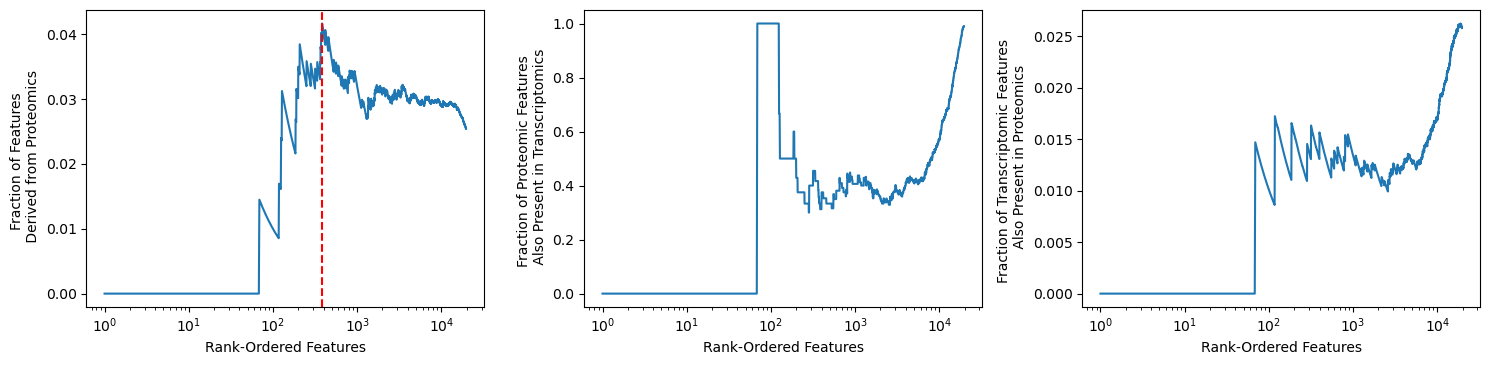

In [11]:
fig, ax = plt.subplots(figsize = (15,3.75), ncols = 3)

sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Protein Feature Fraction', 
            ax = ax[0])
ax[0].set_xlabel('Rank-Ordered Features')
ax[0].set_xscale('log')
ax[0].set_ylabel('Fraction of Features \n Derived from Proteomics')
ax[0].axvline(x=top_prot_feature, color='red', linestyle='--')


sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Shared Genes Fraction - Protein', 
             ax = ax[1])
ax[1].set_xlabel('Rank-Ordered Features')
ax[1].set_xscale('log')
ax[1].set_ylabel('Fraction of Proteomic Features \n Also Present in Transcriptomics')


sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Shared Genes Fraction - RNA', 
             ax = ax[2])
ax[2].set_xlabel('Rank-Ordered Features')
ax[2].set_xscale('log')
ax[2].set_ylabel('Fraction of Transcriptomic Features \n Also Present in Proteomics')

fig.tight_layout()
;



In [12]:
msg = 'Whereas all {} RNA features were selected in the model, '.format(len(selected_rna_cols))
msg += 'only {} of the protein features were selected'.format(len(selected_protein_cols))
protein_frac_all = 100*len(selected_protein_cols)/len(selected_cols)
msg += '. Thus, protein features comprise {:.2f}% of all features used in the model'.format(protein_frac_all) 

protein_frac = 100*model_coefs[model_coefs['Feature Rank'] == top_n]['Protein Feature Fraction'].tolist()[0]
msg +='. They comprise {:.2f}% of the top 500 features'.format(protein_frac)

print(msg)
print('')
print('The fraction of features derived from protein peaks at the top {} feature at {:.2f}%'.format(top_prot_feature, 100 * model_coefs['Protein Feature Fraction'].max()))




Whereas all 19138 RNA features were selected in the model, only 500 of the protein features were selected. Thus, protein features comprise 2.55% of all features used in the model. They comprise 3.60% of the top 500 features

The fraction of features derived from protein peaks at the top 384 feature at 4.17%


Regarding the first panel, this suggests a weighting of proteomics in the top features, which aligns with the fact that they help improve predictive performance.

In [13]:
all_features_shared_prot = 100*model_coefs['Shared Genes Fraction - Protein'].tolist()[-1]
top_n_shared_prot = 100*model_coefs[model_coefs['Feature Rank'] == top_n]['Shared Genes Fraction - Protein'].tolist()[0]
max_frac_shared_prot = 100*model_coefs[model_coefs['Feature Rank'] == top_prot_feature]['Shared Genes Fraction - Protein'].tolist()[0]
all_shared_prot = [all_features_shared_prot, top_n_shared_prot, max_frac_shared_prot]

msg = 'The percent of proteomics features that are in common with transcriptomics is'
msg += ' {:.2f}%, {:.2f}%, {:.2f}%'.format(*all_shared_prot)
msg += ' for all features used by the model, the top 500 features, '
msg += 'and the top {} features (where the fraction of features that is dervied from proteomics is maximized)'.format(top_prot_feature)
msg += ' , respectively.'
print(msg)


The percent of proteomics features that are in common with transcriptomics is 99.00%, 33.33%, 31.25% for all features used by the model, the top 500 features, and the top 384 features (where the fraction of features that is dervied from proteomics is maximized) , respectively.


Regarding the second panel, this tells us that while features representing the same gene between transcriptomics and proteomics do add information,they are substantially less heavily favored in the more influential set of top-ranked features (fewer features are shared in the top 500 than in all features used in the dataset).

In [35]:
files = [os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'), 
        os.path.join(data_path, 'processed', 'uniprot_mapper.json'), 
        os.path.join(data_path, 'processed',  'expr_joint.csv'), 
        os.path.join(data_path, 'processed',  'expr_protein.csv'), 
        os.path.join(data_path, 'processed',  'expr.csv'), 
        os.path.join(data_path, 'processed', 'best_model_svr_linear_joint.pickle'), 
        os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv')]

for fn in files:
    msg = 'scp hmbaghda@satori-login-002.mit.edu:' + fn + ' for_Arjana/.'
    print(msg)
    print('')

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/rank_ordered_joint_features.csv for_Arjana/.

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/uniprot_mapper.json for_Arjana/.

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/expr_joint.csv for_Arjana/.

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/expr_protein.csv for_Arjana/.

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/expr.csv for_Arjana/.

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/best_model_svr_linear_joint.pickle for_Arjana/.

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/metastatic_potential_joint.csv for_Arjana/.

